In [63]:
import os
import pandas as pd
import seaborn as sns
from IPython.display import display

In [64]:
## Set Up CWD and Data folder ##

CWD = os.getcwd()
DATA_PATH = os.path.join(CWD, "data")

FILE_NAME = "ts_kaggle_train.csv"
TRAIN_CSV_PATH = os.path.join(DATA_PATH, FILE_NAME)

In [65]:
## Set Up DataFrames ##
df = pd.read_csv(TRAIN_CSV_PATH, index_col = 0)
df.sample(5)

,date,unique_id,city_id,shop_id,item_category_id,item_id,monthly_average_price,monthly_sales
2030,2015-01-31,21_16227,7,21,65,16227,419.000000,4.0
588,2014-05-31,15_2308,2,15,30,2308,298.964286,11.0
5171,2014-07-31,28_7893,7,28,6,7893,1789.970000,11.0
7408,2014-12-31,31_15446,7,31,63,15446,542.333333,7.0
1530,2014-01-31,19_1905,6,19,30,1905,249.000000,2.0


In [66]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14484 entries, 0 to 14483
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   date                   14484 non-null  object 
 1   unique_id              14484 non-null  object 
 2   city_id                14484 non-null  int64  
 3   shop_id                14484 non-null  int64  
 4   item_category_id       14484 non-null  int64  
 5   item_id                14484 non-null  int64  
 6   monthly_average_price  13262 non-null  float64
 7   monthly_sales          13756 non-null  float64
dtypes: float64(2), int64(4), object(2)
memory usage: 1018.4+ KB


In [67]:
df["date"] = pd.to_datetime(df["date"], format = "%Y-%m-%d")

In [68]:
df.isnull().sum()

date                        0
unique_id                   0
city_id                     0
shop_id                     0
item_category_id            0
item_id                     0
monthly_average_price    1222
monthly_sales             728
dtype: int64

<Axes: xlabel='unique_id', ylabel='date'>

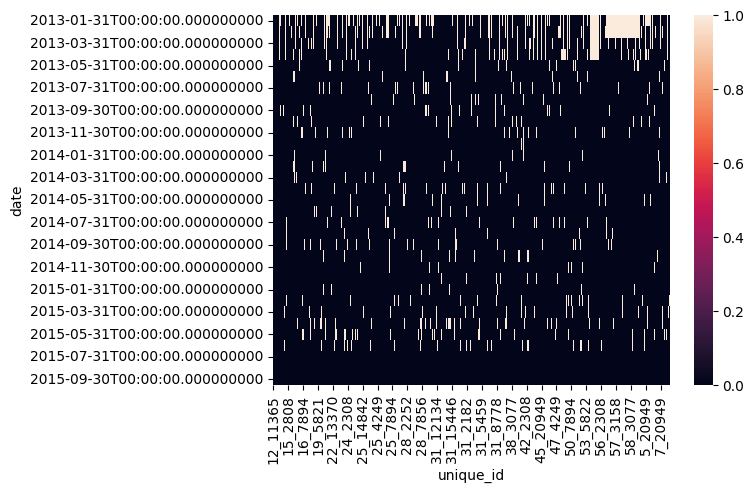

In [69]:
pt = df.pivot_table(
    index = "date",
    columns = "unique_id",
    values = "monthly_average_price"
).isnull()

sns.heatmap(pt)

<Axes: xlabel='unique_id', ylabel='date'>

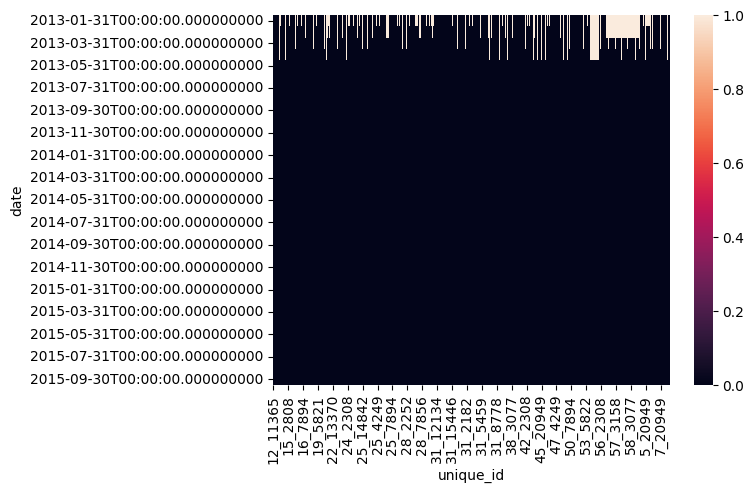

In [70]:
pt = df.pivot_table(
    index = "date",
    columns = "unique_id",
    values = "monthly_sales"
).isnull()

sns.heatmap(pt)

In [71]:
df.head()

,date,unique_id,city_id,shop_id,item_category_id,item_id,monthly_average_price,monthly_sales
0,2013-01-31,12_11365,16,12,9,11365,1511.512626,30.0
1,2013-01-31,12_11369,16,12,9,11369,572.715278,30.0
2,2013-01-31,12_11370,16,12,9,11370,699.776786,30.0
3,2013-01-31,12_11373,16,12,9,11373,548.900000,6.0
4,2013-01-31,12_12231,16,12,49,12231,350.000000,3.0


In [72]:
df.fillna({"monthly_sales":0}, inplace= True)

In [73]:
df["monthly_average_price"] =\
    df.groupby(["unique_id"])["monthly_average_price"].transform(lambda series: series.bfill().ffill())

In [74]:
df.isnull().sum()

date                     0
unique_id                0
city_id                  0
shop_id                  0
item_category_id         0
item_id                  0
monthly_average_price    0
monthly_sales            0
dtype: int64

In [75]:
df.groupby(["date", "shop_id"])["monthly_sales"].sum()

date        shop_id
2013-01-31  3            2.0
            4           80.0
            5            0.0
            6          102.0
            7           63.0
                       ...  
2015-10-31  55           0.0
            56           0.0
            57           0.0
            58           0.0
            59           0.0
Name: monthly_sales, Length: 1190, dtype: float64

In [76]:
df.set_index("date").resample("3ME")["monthly_sales"].sum() #ME / #YE

date
2013-01-31     2303.0
2013-04-30     7374.0
2013-07-31     8744.0
2013-10-31     9186.0
2014-01-31    10941.0
2014-04-30     9699.0
2014-07-31     8487.0
2014-10-31     9601.0
2015-01-31    12778.0
2015-04-30     9455.0
2015-07-31     7275.0
2015-10-31     5097.0
Freq: 3ME, Name: monthly_sales, dtype: float64

In [88]:
# mejor praxis que el group by. Resample es para los años, meses, dias, para filtrar y crear adhoc dataframes

gbdf_shop = (
    df.set_index("date")
    .groupby(["shop_id"])
    .resample("ME")
    ["monthly_sales"]
    .sum()
    .reset_index()
)

gbdf_shop["monthly_sales_lag1"] =\
    gbdf_shop.groupby(["shop_id"])["monthly_sales"].transform(
        lambda series: series.shift(1)
    )

gbdf_shop

,shop_id,date,monthly_sales,monthly_sales_lag1
0,3,2013-01-31,2.0,NaN
1,3,2013-02-28,1.0,2.0
2,3,2013-03-31,1.0,1.0
3,3,2013-04-30,1.0,1.0
4,3,2013-05-31,3.0,1.0
...,...,...,...,...
1185,59,2015-06-30,46.0,55.0
1186,59,2015-07-31,48.0,46.0
1187,59,2015-08-31,68.0,48.0
1188,59,2015-09-30,30.0,68.0


In [89]:
#%%timeit
gbdf_city = (
    df.set_index("date")
    .groupby(["city_id"])
    .resample("ME")
    ["monthly_sales"]
    .sum()
    .reset_index()
)

gbdf_city["monthly_sales_lag1_t"] =\
    gbdf_city.groupby(["city_id"])["monthly_sales"].transform(
        lambda series: series.shift(1)
    )

gbdf_city

,city_id,date,monthly_sales,monthly_sales_lag1_t
0,0,2013-01-31,2.0,NaN
1,0,2013-02-28,1.0,2.0
2,0,2013-03-31,1.0,1.0
3,0,2013-04-30,1.0,1.0
4,0,2013-05-31,3.0,1.0
...,...,...,...,...
811,23,2015-06-30,46.0,55.0
812,23,2015-07-31,48.0,46.0
813,23,2015-08-31,68.0,48.0
814,23,2015-09-30,30.0,68.0


In [90]:
#1: Implementar la lógica
#2: Refactorizar
#3: optimizar

In [ ]:
def build_ts_features(df, gb_list, target_column, lag):
    
    new_name = "_".join(gb_list)
    
    gbdf_shop = (
        df
        .set_index("date")
        .groupby(gb_list)
        .resample("M")
        [target_column]
        .sum()
        .reset_index()
    )
    for n in range(1, lag + 1): 
        gbdf_shop[f"{new_name}_{target_column}_lag_{n}"] =\
        gbdf_shop.groupby(gb_list)[target_column].transform(
            lambda series: series.shift(n)
        )
    return gbdf_shop